In [2]:
suppressMessages(library(tidyverse))
suppressMessages(library(ggplot2))

suppressMessages(library(openair))

In [3]:
suppressMessages(library(doMC))
registerDoMC(cores=as.integer(detectCores()*0.75))

In [4]:
suppressMessages(library(repr))
options(repr.plot.width=25,
        repr.plot.height=10,
        #repr.plot.pointsize=50,
        repr.plot.family='serif'
       )

In [5]:
setwd("~/Repositories/AirQualityCOVID/")

In [6]:
method <- "lm"

load(paste("data/Cross-validation/", method, ".rda", sep=""))

In [7]:
pollut.notation <- c("no" = expression(NO),
                     "no2" = expression(NO[3]),
                     "o3" = expression(O[3]),
                     "pm10" = expression(PM[10]),
                     "pm2.5" = expression(PM[2.5])
                    )
Error.notation <- c("bias" = "Bias Ratio",
                    "cor1" = "Correlation",
                    "cor2" = "Deseasonal Correlation",
                    "RMSE" = "Root Mean Square Error",
                    "var.ratio" = "Ratio of Variance"
                   )
site.notation <- c("es0118a" = "Madrid", "es1438a" = "Barcelona",
                   "es1625a" = "Valencia", "es0890a" = "Sevilla",
                   "es1047a" = "Zaragoza", "es1137a" = "Vigo",
                   "es1632a" = "Valladolid", "es0110a" = "Bilbao",
                   "es1580a" = "Santander", "es1340a" = "Huelva"
                   )


param.text <- list("rf" = "ntree", "knn" = "k-neighbors")

# Metricas

In [8]:
pivot.metrics <- cross.val$metrics %>%
        pivot_longer(cols = 7:ncol(cross.val$metrics),
                     names_to = "Error", values_to = "Err.Val")

In [9]:
dat.df <- pivot.metrics %>%
            filter(
                days %in% 0:3,
                site %in% c(
                            #"es0118a", "es1438a", 
                            #"es1625a", "es0890a", 
                            #"es1047a", "es1137a",
                            "es1632a"#, "es0110a",
                            #"es1580a", "es1340a"
                            ),
                variable %in% c(
                                "no", 
                                "no2", 
                                "o3", 
                                "pm10", 
                                "pm2.5"
                                ),
                year %in% 2013:2019,
                param %in% c(0,
                             # k-NN
                             1:10,
                             # randomForest
                             10, 20, 30, 50, 100, 150, 200),
                qq.Mapping %in% c(
                                  "Yes"
                                  #"No"
                                  ),
                Error %in% c(
                             "bias", 
                             "cor1", 
                             "cor2", 
                             "var.ratio", 
                             "RMSE"
                             )
            )

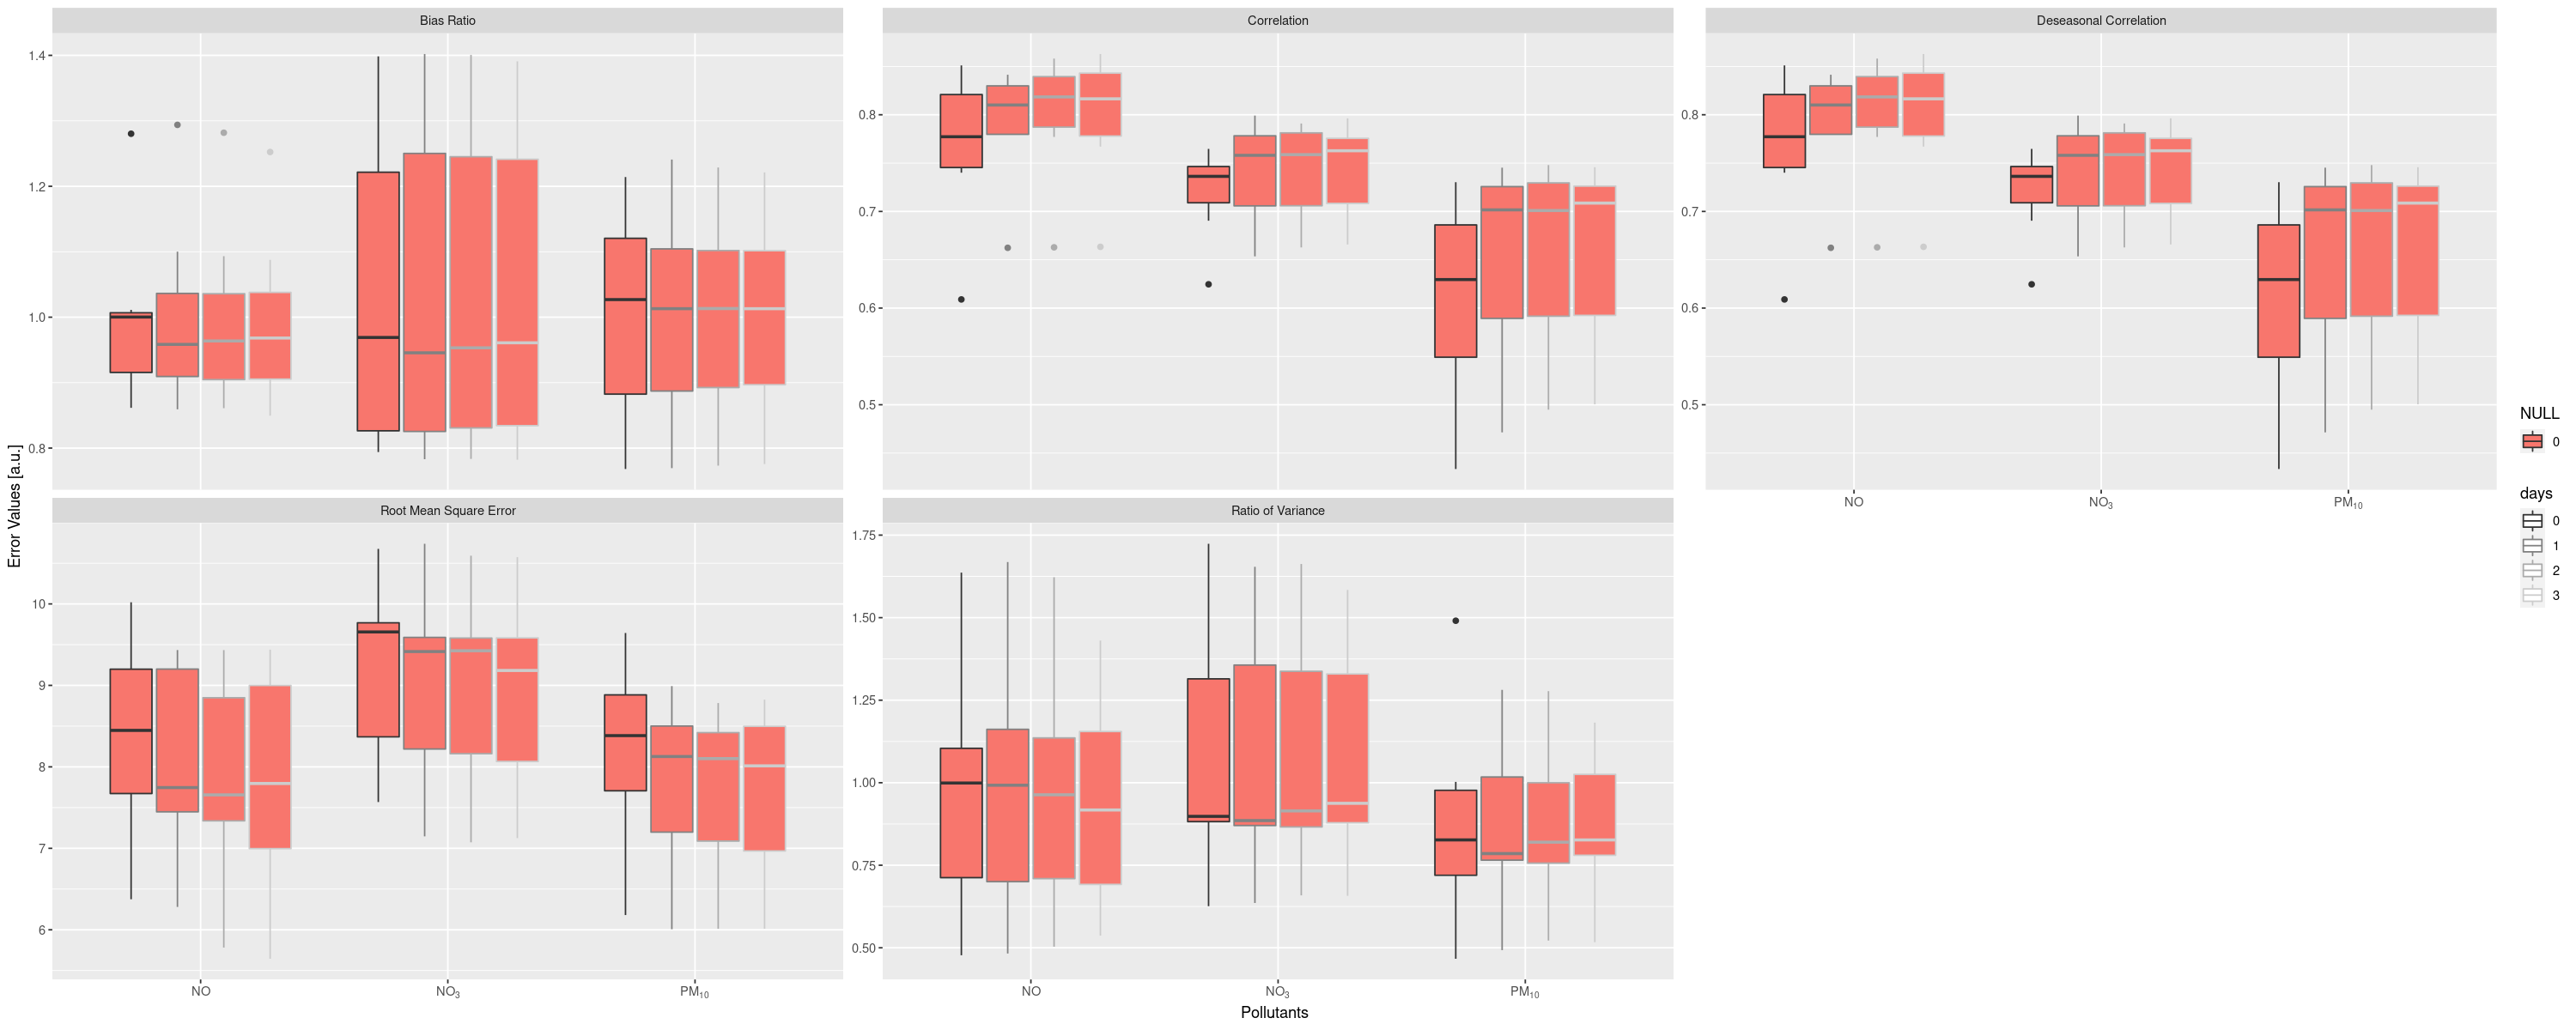

In [10]:
ggplot(data=dat.df) +
    geom_boxplot(aes(x=variable, y=Err.Val, fill=param, color=days)) +
    scale_color_grey() +
    facet_wrap(~Error, 
               scale="free_y", 
               labeller = labeller(Error=Error.notation)) +
    scale_x_discrete(name="Pollutants", labels=pollut.notation) +
    scale_y_continuous(name="Error Values [a.u.]") +
    scale_fill_discrete(name=param.text[method])

# Predicciones

In [18]:
predict.df <- cross.val$predictions %>%
            filter(
                days %in% 0:3,
                site %in% c(
                            "es0118a", "es1438a", 
                            "es1625a", "es0890a", 
                            "es1047a", "es1137a",
                            "es1632a", "es0110a",
                            "es1580a", "es1340a"
                            ),
                variable %in% c(
                                "no", 
                                "no2",
                                "o3", 
                                "pm10",
                                "pm2.5"
                                ),
                year %in% 2013:2019,
                param %in% c(0, #10,
                             # k-NN
                             4:5,
                             # randomForest
                             20, 30, 50, 100, 150, 200)
            )

```R
ggplot(data=predict.df) +
        #geom_point(aes(x=obs, y=pred), color = "red") +
        geom_point(aes(x=obs, y=pred.qq, color = param)) +
        geom_line(aes(x=obs, y=obs), color = "black") +
        facet_wrap(~variable, scale="free")
```

In [19]:
predict.df$variable <- as.factor(predict.df$variable)

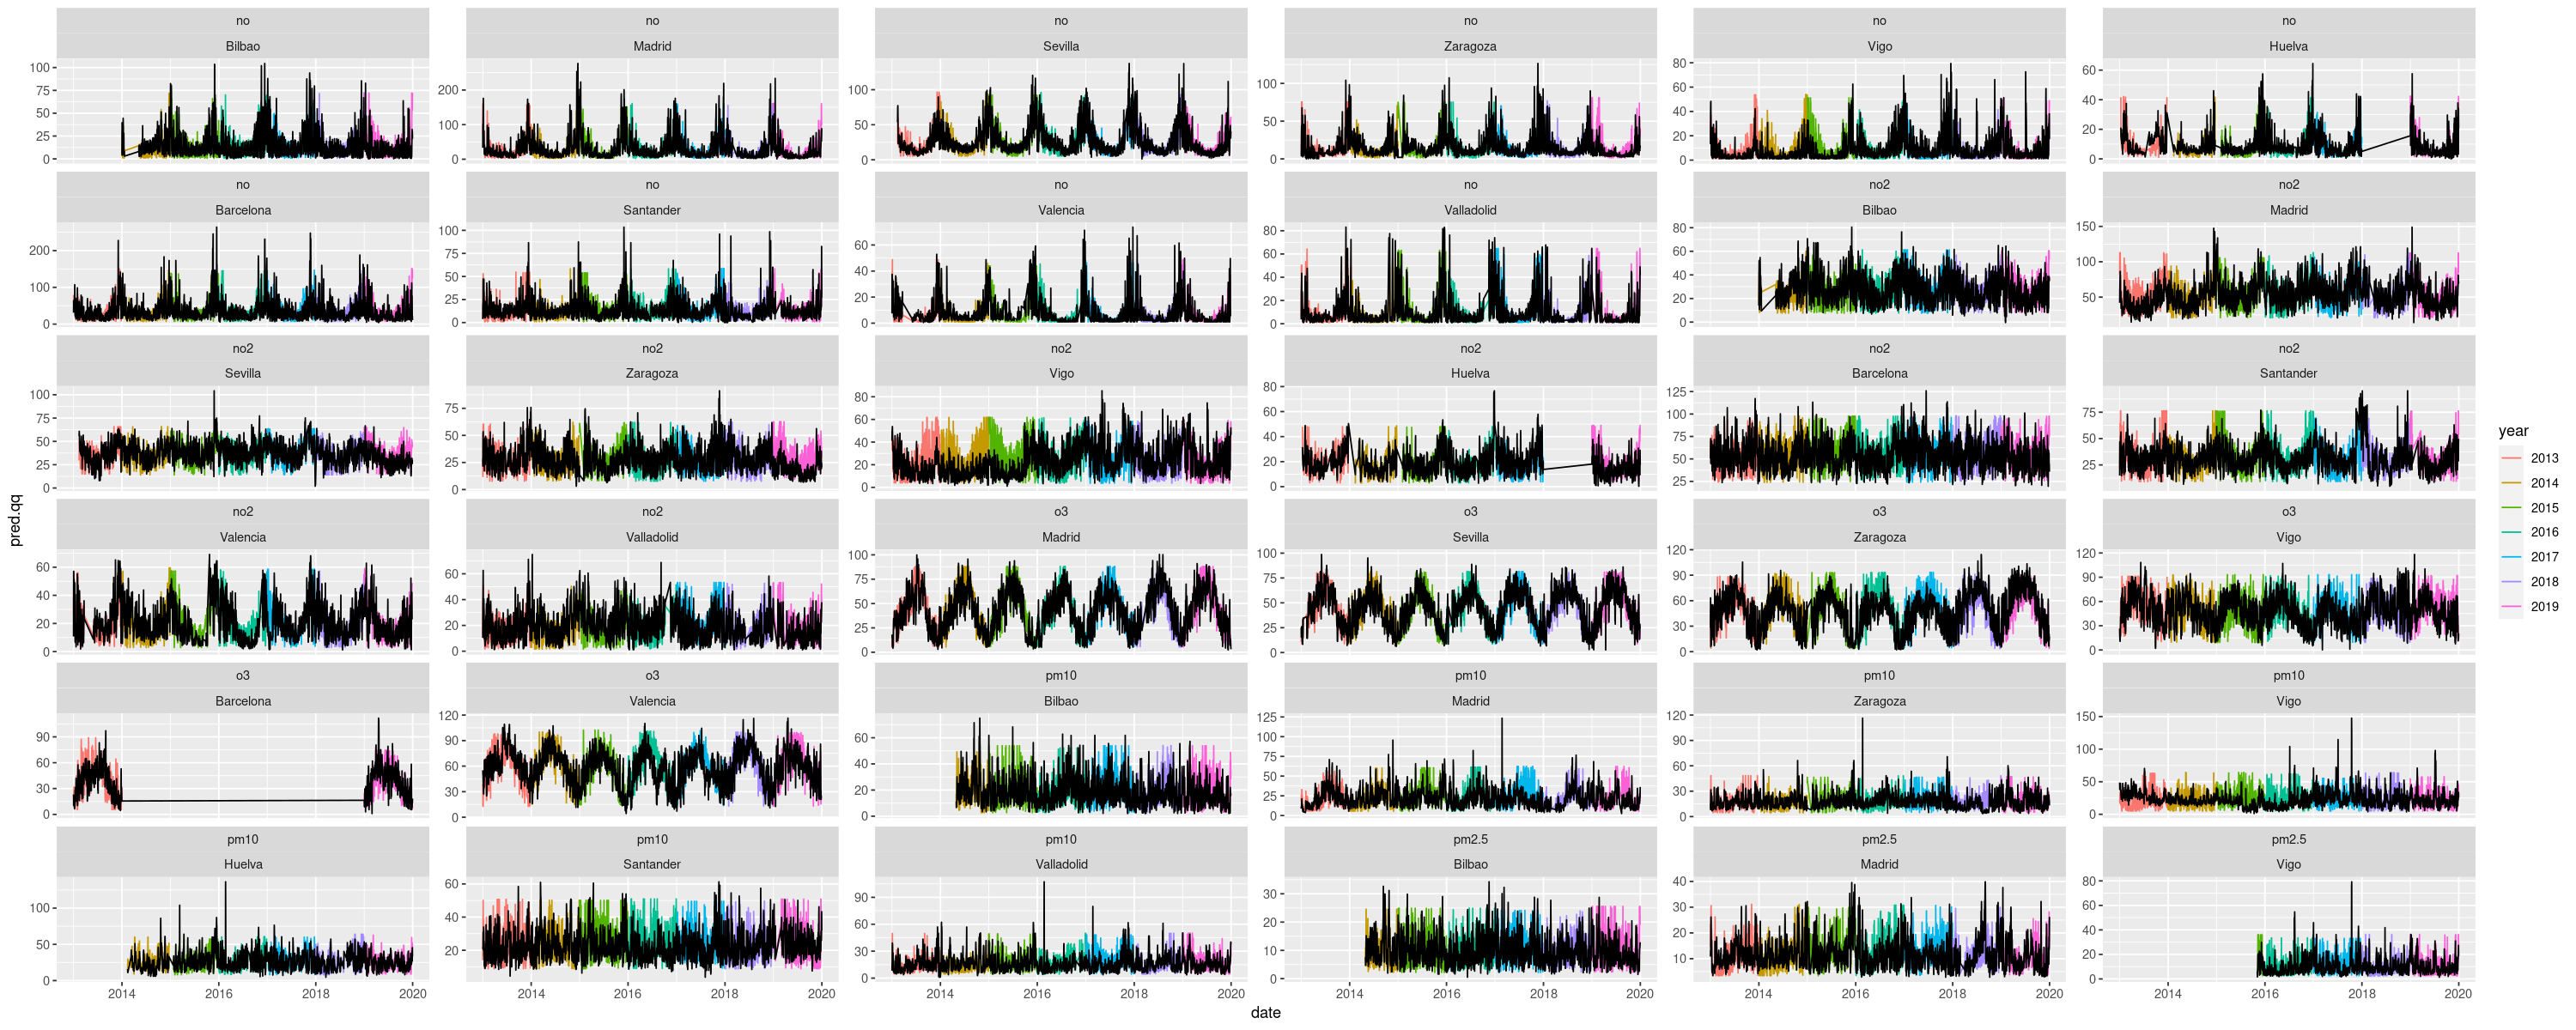

In [26]:
ggplot(data=predict.df) +
    geom_line(aes(x=date, y=pred.qq, color = year)) +
    geom_line(aes(x=date, y=obs), color = "black") +
    facet_wrap(~variable+site, 
               scale="free_y", 
               labeller = labeller(variable =  pollut.notation,
                                   site = site.notation))

In [13]:
test <- predict.df %>%
            rename(value = pred.qq) %>%
            timeAverage(avg.time = "2 week", 
                        type = c("days", "site", "variable", "param"))
test$variable <- factor(test$variable, labels=c(expression(NO),
                                                expression(NO[3]),
                                                expression(O[3]),
                                                expression(PM[10]),
                                                expression(PM[2.5])))

In [14]:
head(test$variable)

[1] NO NO NO NO NO NO
Levels: NO NO[3] O[3] PM[10] PM[2.5]

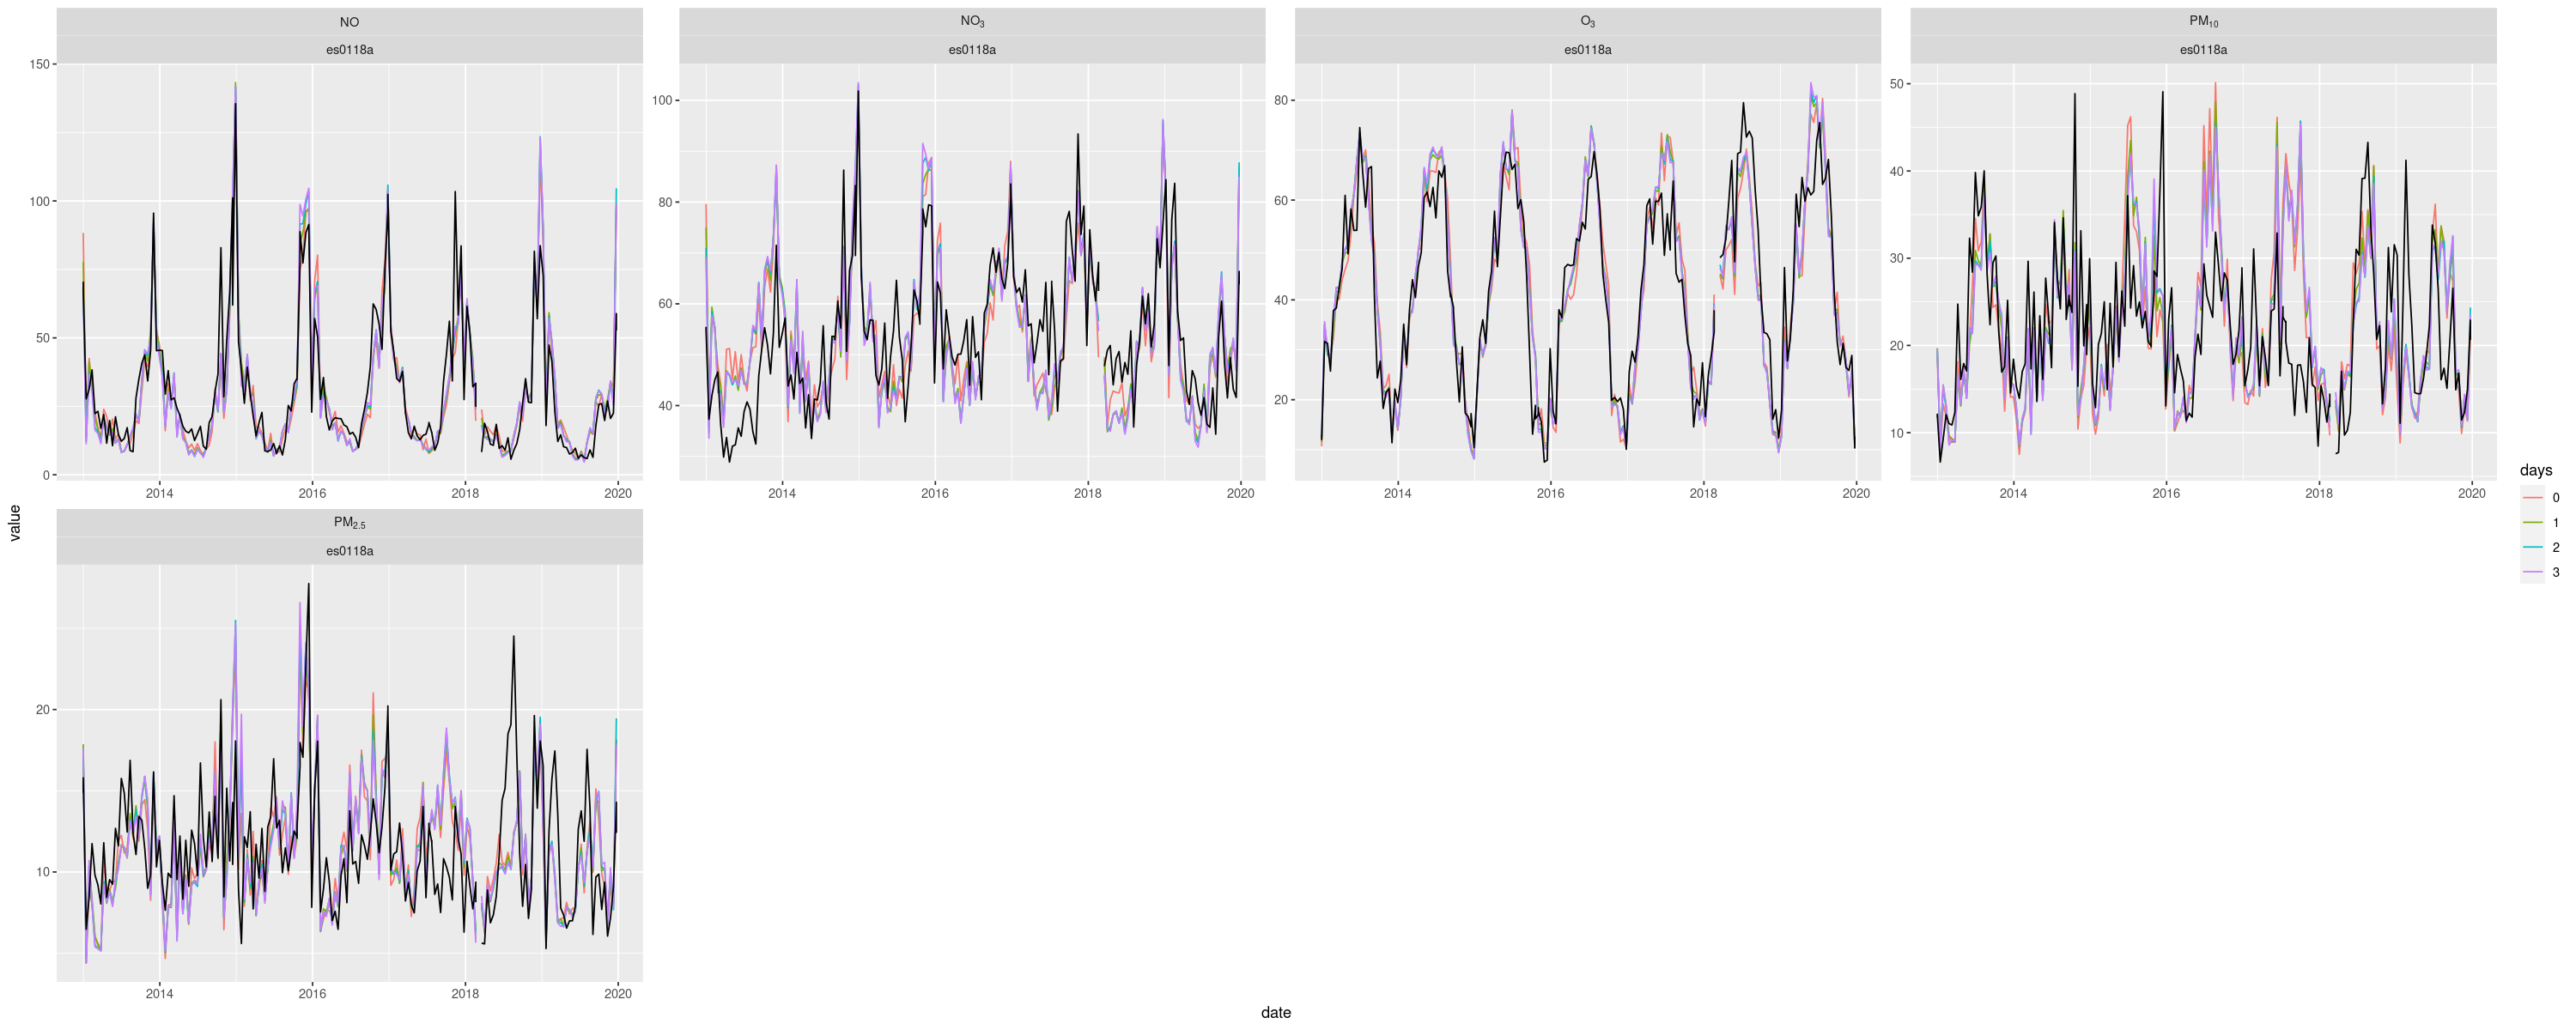

In [15]:
ggplot(data=test) +
    geom_line(aes(x=date, y=value, color = days)) +
    geom_line(aes(x=date, y=obs), color = "black") +
    facet_wrap(~variable+site, scale="free", ncol=4, labeller=label_parsed)

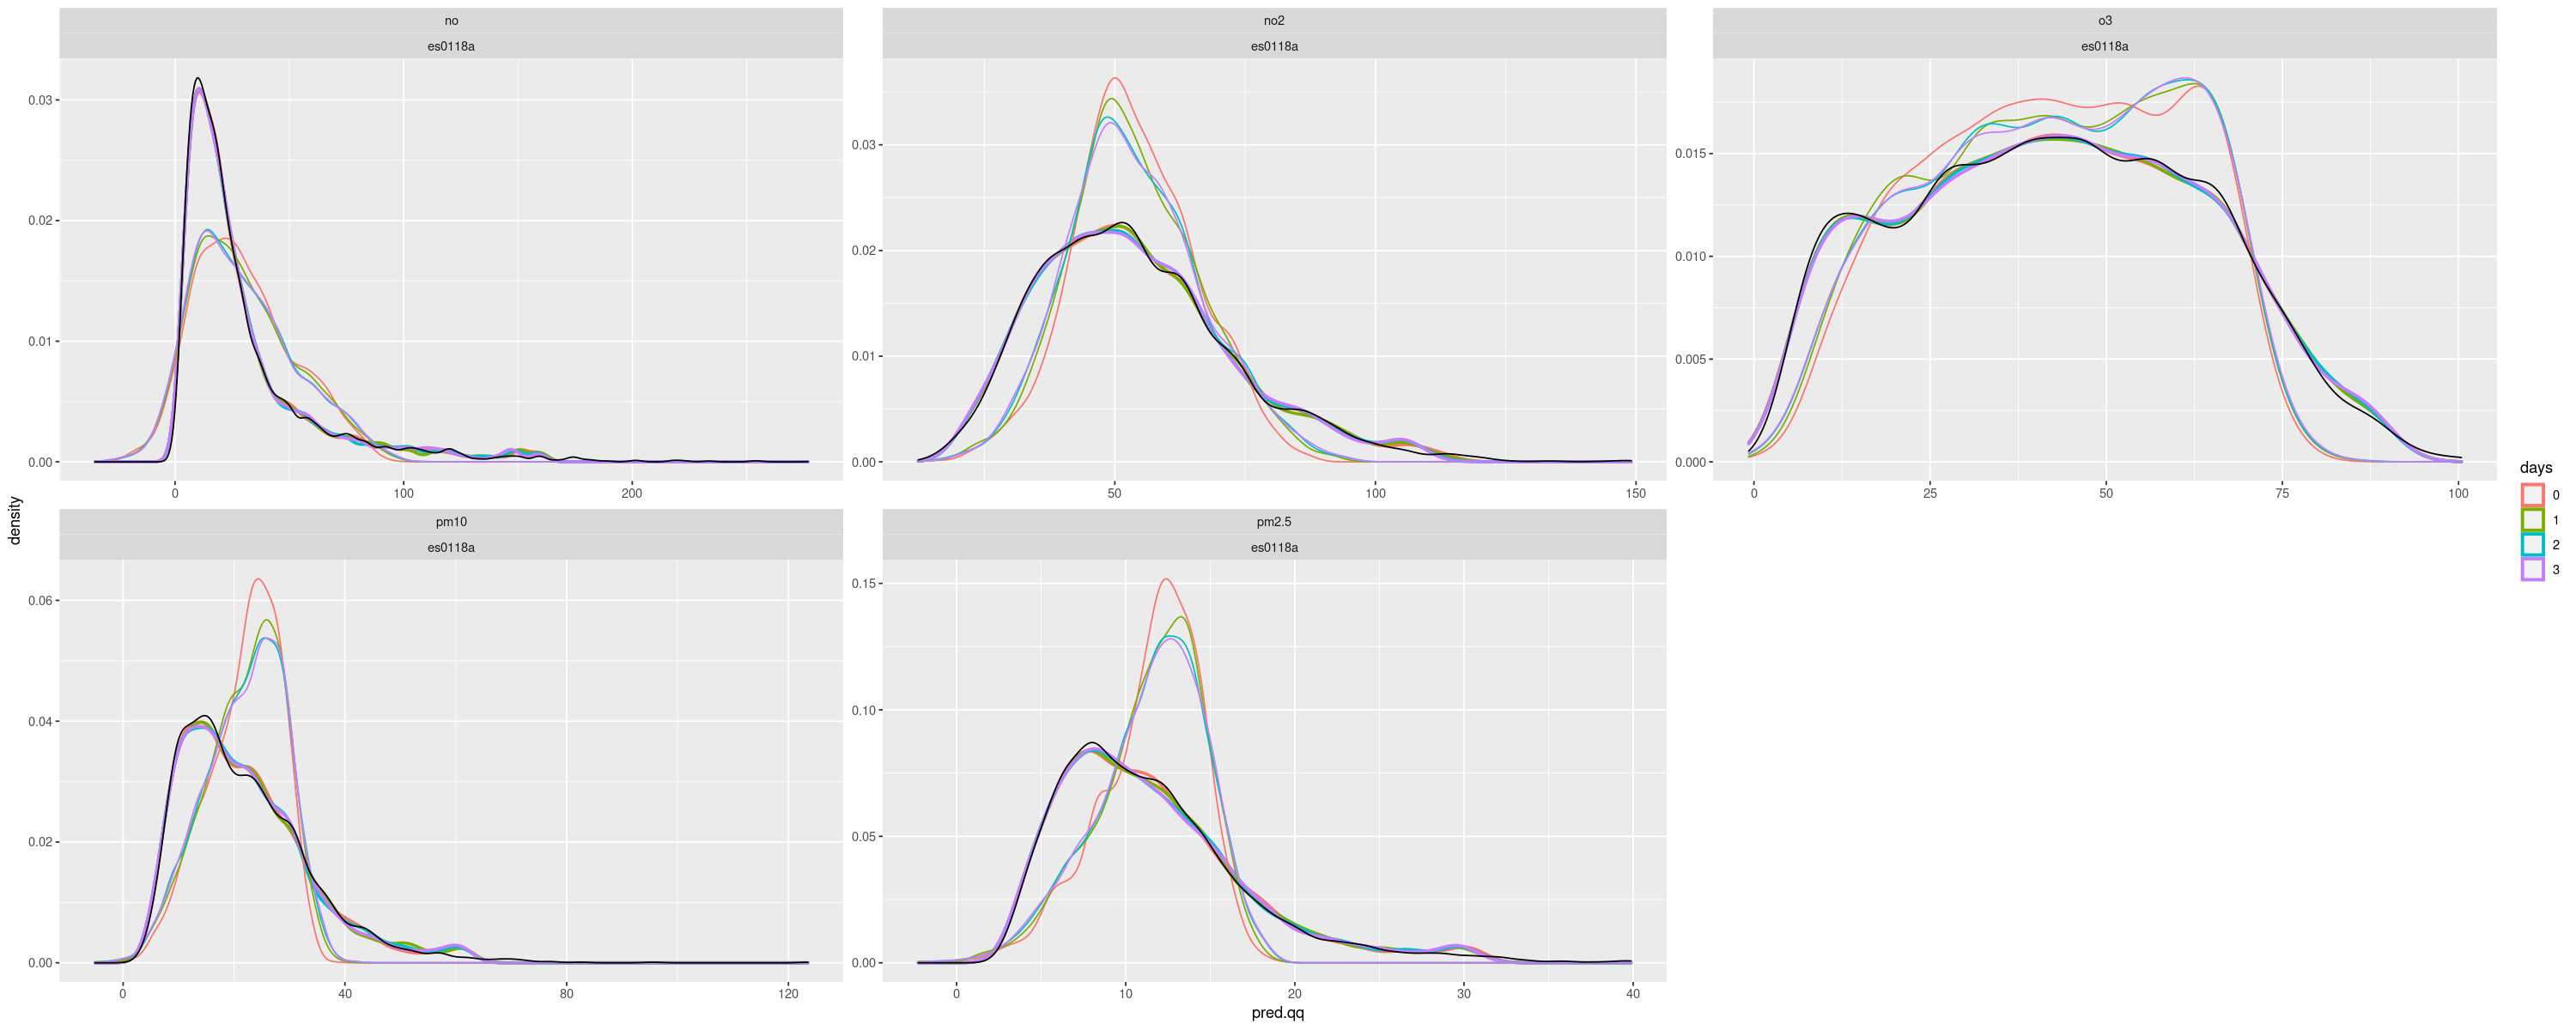

In [16]:
ggplot(data=predict.df) +
    geom_density(aes(x=pred.qq, color=days), size=1) +
    geom_density(aes(x=pred, color=days), size=0.5) +
    geom_density(aes(x=obs), color="black") +
    facet_wrap(~variable+site, scale="free")

In [17]:
#```R
ggsave(plot = last_plot(), 
           filename = "prueba_%03d.png",
           device = "png", 
           path = "~/Desktop/pruebas",
           width = 15,
           height = 10,
          )
#```